# Part 3 - Calculation of the Period and overall Transit Time 

In [1]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee

import corner
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

In [2]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')


class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp,timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        #PROPERTIES OF THE STAR 
        self.mass = mass  # Solar masses
        self.mass_err = mass_err
        self.radius = radius # Solar radii
        self.radius_err = radius_err
        
        self.teff = teff
        self.teff_err = teff_err
        self.logg = logg
        self.feh = feh
    
        #PROPERTIES OF THE PLANET
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires that Rp be in Earth radii
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
        
        #self.lld = lld # Linear LD coeff (Joey)
        #self.qld = qld # Quadratic LD coeff (Joey)  
        
        self.u1 = 0.0 # Claret
        self.u2 = 0.0 # Claret
        self.diffld = u2 - u1
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
        
        self.optimize1 = np.empty(0)
       
        self.p_final = 0.0
        self.t0_final = 0.0
        
    def Print(self):
        print("Star {}".format(self.name))

In [3]:
num = 12

In [4]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.07, 0.08, 0.12, 0.15, 0.08, 0.18, 0.15])
tr_window = transit_range+transit_range # In days

In [5]:
targets = []
for i in range(0,num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    #Logg
    logg = physical["logg"][i]
    feh = physical["feh"][i]
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)
    
    u1 = 0.0
    u2 = 0.0
    
    #lld = targetParams["LLD"][i] # Linear 
    #qld = targetParams["QLD"][i] # Quadratic
    
    # This will upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC)
    
    # Note: THE PARAMETERS BELOW ARE DIFFERENT (transwindow = 2*transrange)
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

In [10]:
import kplr
from kplr.ld import get_quad_coeffs

def quadraticLD(star): #Model: Claret 2011.
    """
    Get the quadratic coefficients for the standard Kepler limb-darkening
    profile.
    
    :param teff: The effective temperature in degrees K.
    :param logg: The log10 surface gravity in cm/s/s.
    :param feh: The metallicity [Fe/H].
        
    """
    getmu1, getmu2 = get_quad_coeffs(star.teff, star.logg, star.feh)
    return getmu1, getmu2


print "  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u2-u1)  *** "
print ""

for star in targets:
    mu1, mu2 = quadraticLD(star)
    print "Star", star.name, ":", mu1, mu2, mu1-mu2
    star.u1 = mu1
    star.u2 = mu2
    star.diffLD = mu1-mu2

  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u2-u1)  *** 

Star 201516974 : 0.7867 -0.0114 0.7981
Star 201920032 : 0.4089 0.2556 0.1533
Star 205924614 : 0.678 0.0894 0.5886
Star 205985357 : 0.4415 0.2396 0.2019
Star 206029314 : 0.4906 0.1813 0.3093
Star 206038483 : 0.4089 0.2556 0.1533
Star 206061524 : 0.6656 0.0853 0.5803
Star 206082454 : 0.3858 0.2711 0.1147
Star 206155547 : 0.3277 0.2981 0.0296
Star 206245553 : 0.3643 0.2807 0.0836
Star 206247743 : 0.5362 0.1609 0.3753
Star 206311743 : 0.5508 0.1646 0.3862


In [11]:
def processStar(star):
    
    goodP = intro(star)  
    mark_transits(star)
   
    transit_window(star, goodP)
    print "Nº of transits (theory):", len(star.transits), " at ", star.transits
    
    out_trans = out_transit(star)
    oot_fit(star)
    print "Nº of transits (observed):", len(star.transits)
    print "Standard deviation of the folded LC:", star.error_foldedLC

In [12]:
def intro(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

In [13]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -25
    maxepoch = 25
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits

In [14]:
def transit_window(star, goodP):
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0, len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

In [15]:
def out_transit(star):
    print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

In [16]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
        
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0,len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Correct Flux again (needed if we had to some star.transits didn't have data)
    
    corFlux2 = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 
    
    #Calculate the standard dev. of the folded LC 
    
    star.f_trans = corFlux2
    star.error_foldedLC = np.std(corFlux2)

In [17]:
new_targets = np.empty(0)

for i in range(0, len(targets)):    
    if (targets[i].name != "205985357") and (targets[i].name != "206247743") and (targets[i].name != "206311743"):
        new_targets = np.append(new_targets, targets[i])
        
for star in new_targets:
    print "Star ", star.name

print len(new_targets)

#  205985357: False Positive
#  206247743: False Positive 
#  206311743: False Positive

Star  201516974
Star  201920032
Star  205924614
Star  206029314
Star  206038483
Star  206061524
Star  206082454
Star  206155547
Star  206245553
9


In [23]:
for star in new_targets:
    print "Target ", star.name 
    print ""
    processStar(star)
    print ""
    print "------------------------------------------------------------------------------------------------"

Target  201516974

Nº of transits (theory): 2  at  [ 1986.80555162  2023.51544261]
Range of the transit (visual estimate): 0.4
Nº of transits (observed): 2
Standard deviation of the folded LC: 0.000906083133742

------------------------------------------------------------------------------------------------
Target  201920032

Nº of transits (theory): 3  at  [ 2000.205774    2028.47744553  2056.74911706]
Range of the transit (visual estimate): 0.18
Nº of transits (observed): 3
Standard deviation of the folded LC: 0.000359300685019

------------------------------------------------------------------------------------------------
Target  205924614

Nº of transits (theory): 22  at  [ 2150.424485    2153.27382604  2156.12316707  2158.97250811  2161.82184914
  2164.67119018  2167.52053121  2170.36987225  2173.21921328  2176.06855432
  2178.91789535  2181.76723639  2184.61657742  2187.46591846  2190.31525949
  2193.16460053  2196.01394156  2198.8632826   2201.71262363  2204.56196467
  2207.411

## Determine the orbital period and the midtransit time

Initial guess: Linear fit of individual transit times.
Improve calculation with Levenberg–Marquardt algorithm

In [32]:
def func(x, a, b): 
    return (a*x + b)

def oc(star, obst0, upper_error, lower_error):
    aux = 0
    
    # Find if there are any missing transits
    
    print "  -> Time diff b/w consecutive transits/period (t/p):"
    
    for i in range (0, len(star.transits)):
        timediff = obst0[i]-obst0[i-1]
        missing_transits = round(timediff/star.per) #if numtransits = 2, then there's a missing transit. If 3, there will be 3. 
        
        if i == 0: 
            missing_transits = 1.0
        
        print "      Transit nº", i+1, ": t/p = ", missing_transits
        aux = aux + missing_transits 
    
    num_obs = len(star.transits)
    num_theo = aux
    missing = num_theo-num_obs
    print ""
    print "  -> Nº of missed Transits: ", missing
    
     
    if num_theo == num_obs: # If nº of theoretical transits is the same as the nº of observed transits
        n = np.empty(len(star.transits))
        tobs = np.empty(len(star.transits))
        tobsErr = np.empty(len(star.transits))
         
        for i in range(0, len(n)):
            n[i] = i
        
        for i in range (0, len(star.transits)):
            aux = obst0[i]    
            auxerr = (upper_error[i] + lower_error[i])/2 
            tobs[i] = aux
            tobsErr[i] = auxerr 
        
        tobs = np.array(tobs)
        tobsErr = np.array(tobsErr)


    if num_theo != num_obs:    # If nº of theoretical transits does NOT match the nº of observed transits
        
        newsize = int(len(star.transits) + missing)
        print "  -> Nº of Theoretical Transits:", newsize
        
        tobs = np.zeros(newsize)
        tobsErr = np.zeros(newsize)
        err_observedt0 = []
        observedt0 = []
        
        print "  -> When are the missing transits?:"
        print ""
        
        for i in range(0, len(star.transits)):    
            timediff = obst0[i]-obst0[i-1]
            missedTrans = round(timediff/star.per) #if missedTrans = 2, then there's a missing transit. If 3, there will be 2. 
            
            if i == 0: 
                missedTrans = 1.0
            
            err_observedt0.append((upper_error[i] + lower_error[i])/2)
            
            if missedTrans != 1.0:
                time_missing = obst0[i-1] + (missedTrans-1)*star.per
                print "        ", time_missing
                observedt0.append(time_missing)
                err_observedt0.append(mean_error)        
             
                lower_error = np.insert(lower_error, i, mean_error)
                upper_error = np.insert(upper_error, i, mean_error)
                
            observedt0.append(obst0[i])
            mean_error = np.mean([np.mean(upper_error), np.mean(lower_error)])
           
            
        n = np.empty(newsize)
        
        for i in range(0, len(n)):
             n[i] = i
      
        tobs = np.array(observedt0)
        tobsErr = np.array(err_observedt0)
        
    print ""
    print "  -> 'Observed' t0 (inlcuding missing transits if applicable):"
    print tobs
    print ""
    print "  -> Error of observed t0:"
    print tobsErr
    print ""

    print "Check that  vectors n and tobs have same length:", len(n), len(tobs)

    # Linear fit of observed transit times (plus missed transits if applicable)
    
    k = np.polyfit(n, tobs, 1) 
    slopeP = k[0]
    t0Final = k[1]
    p0 = [slopeP, t0Final] #Initial guesses
   
    print "  -> Initial Guesses (from linear fit of observed t0):"
    print "        Period = ", slopeP, "days"
    print "        t0 = ", t0Final
    print ""
   
    # Curve_fit uses Levenberg–Marquardt_algorithm
    
    popt, pcov = op.curve_fit(func, n, tobs, p0 = [slopeP, t0Final], sigma = tobsErr) 
    perr = np.sqrt(np.diag(pcov)) #Entry 0 = Error of period; Entry 1 = Error of t0
    
    """
        popt: ptimal values for the parameters so that the sum of the squared error of 
        "f(xdata, *popt) - ydata" is minimized. (Array) 

        pcov: The estimated covariance of popt. The diagonals provide the variance of the parameter 
        estimate. To compute one standard deviation errors on the parameters use 
        err = np.sqrt(np.diag(pcov)). (2D Array)
    """
        
    if len(star.transits) == 2: # With 2 points, we can't calculate the error
        perr[0] = 0.0
        perr[1] = 0.0 
    
    print "perr: ", perr
    print "  -> Optimal Values:"
    print ""
    print "        Period = ", popt[0], "+/-", perr[0]
    print "        Transit Time = ", popt[1], "+/-", perr[1]
    print " "
    
    # Calculate O-C: o-c = t obs(n) - t0 - P*n'
    o_c = np.array(tobs) - popt[1] - popt[0]*np.array(n) # 
    
    asymmetric_error = [lower_error, upper_error]
 
    plt.figure(2)
    plt.errorbar(tobs, o_c, yerr = asymmetric_error, fmt='o')
    plt.xlabel('T obs(n)')
    plt.ylabel('O-C Residuals (days)') #Residuals t obs(n) - t0 - P*n'
    plt.xlim([min(tobs)-5,max(tobs)+5])
    plt.title('Residuals for Star '+ star.name, fontsize = 15)
    plt.savefig('3_'+star.name+'OC.jpg', dpi=800)
    plt.show()
    
    return popt, perr

************************ Star 201516974  ************************

  -> Number of observed transits: 2
  -> Observed transit times:
[ 1986.79440402  2023.51944061]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 1986.79440402  2023.51944061]

  -> Error of observed t0:
[ 0.00723663  0.00672043]

Check that  vectors n and tobs have same length: 2 2
  -> Initial Guesses (from linear fit of observed t0):
        Period =  36.72503659 days
        t0 =  1986.79440402

perr:  [ 0.  0.]
  -> Optimal Values:

        Period =  36.72503659 +/- 0.0
        Transit Time =  1986.79440402 +/- 0.0
 


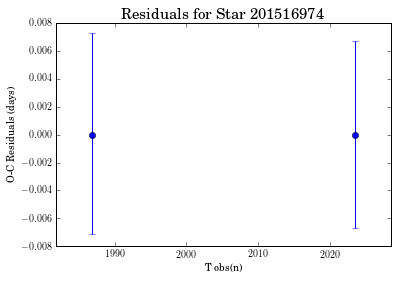

************************ Star 201920032  ************************

  -> Number of observed transits: 3
  -> Observed transit times:
[ 2000.20463467  2028.4678456   2056.74844808]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0
      Transit nº 3 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2000.20463467  2028.4678456   2056.74844808]

  -> Error of observed t0:
[ 0.00405102  0.0083975   0.00493553]

Check that  vectors n and tobs have same length: 3 3
  -> Initial Guesses (from linear fit of observed t0):
        Period =  28.271906705 days
        t0 =  2000.20173608

perr:  [ 0.00308276  0.00382014]
  -> Optimal Values:

        Period =  28.2716926045 +/- 0.00308276144729
        Transit Time =  2000.20375062 +/- 0.00382013735258
 


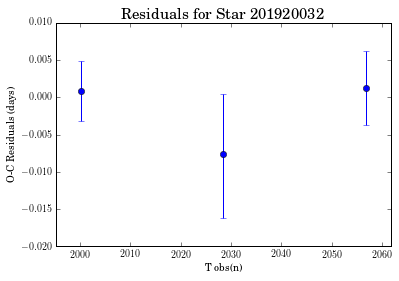

************************ Star 205924614  ************************

  -> Number of observed transits: 20
  -> Observed transit times:
[ 2150.42388189  2156.12198302  2158.97160237  2161.82066995  2164.66798172
  2170.36754856  2173.21688524  2176.06544412  2178.91422392  2181.76353427
  2184.6141246   2187.46287509  2190.31356116  2193.16316347  2196.01120189
  2198.86009793  2201.71055963  2204.55905897  2207.40946643  2210.25922012]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  2.0
      Transit nº 3 : t/p =  1.0
      Transit nº 4 : t/p =  1.0
      Transit nº 5 : t/p =  1.0
      Transit nº 6 : t/p =  2.0
      Transit nº 7 : t/p =  1.0
      Transit nº 8 : t/p =  1.0
      Transit nº 9 : t/p =  1.0
      Transit nº 10 : t/p =  1.0
      Transit nº 11 : t/p =  1.0
      Transit nº 12 : t/p =  1.0
      Transit nº 13 : t/p =  1.0
      Transit nº 14 : t/p =  1.0
      Transit nº 15 : t/p =  1.0
      Transit nº 16 :

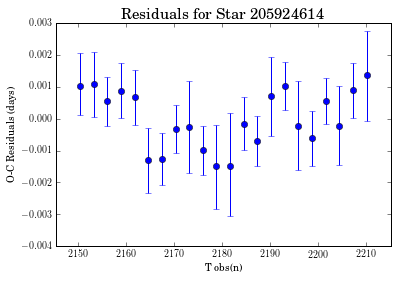

************************ Star 206029314  ************************

  -> Number of observed transits: 10
  -> Observed transit times:
[ 2148.06233316  2155.09564411  2162.12042412  2169.14782339  2176.17181602
  2183.18783733  2190.22259425  2197.25023811  2204.26931601  2211.30950119]

  -> Time diff b/w consecutive transits/period (t/p):
      Transit nº 1 : t/p =  1.0
      Transit nº 2 : t/p =  1.0
      Transit nº 3 : t/p =  1.0
      Transit nº 4 : t/p =  1.0
      Transit nº 5 : t/p =  1.0
      Transit nº 6 : t/p =  1.0
      Transit nº 7 : t/p =  1.0
      Transit nº 8 : t/p =  1.0
      Transit nº 9 : t/p =  1.0
      Transit nº 10 : t/p =  1.0

  -> Nº of missed Transits:  0.0

  -> 'Observed' t0 (inlcuding missing transits if applicable):
[ 2148.06233316  2155.09564411  2162.12042412  2169.14782339  2176.17181602
  2183.18783733  2190.22259425  2197.25023811  2204.26931601  2211.30950119]

  -> Error of observed t0:
[ 0.00189038  0.00280831  0.0041405   0.00233131  0.0038659

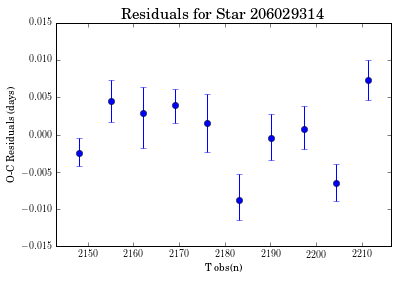

In [ ]:
count = 1

for star in new_targets:
    t0 = np.loadtxt('2_'+star.name+'t0_mcmc.txt', skiprows=1)
    t0_obs = t0[:,0]
    t0_uppererr = t0[:,1]       
    t0_lowererr = t0[:,2]
    
    print "************************ Star", star.name, " ************************"
    print ""
    print "  -> Number of observed transits:", len(star.transits)
    print "  -> Observed transit times:"
    print t0_obs
    print ""
    opt_values, err = oc(star, t0_obs, t0_uppererr, t0_lowererr)
        
    np.savetxt('3_'+star.name+'finalp0t0.txt', np.transpose([opt_values,err]), fmt='%.10f', 
               delimiter = ' ', 
               header = """Column 1 shows the period (row 1) and its uncertainty (row 2). 
                       Column 2 gives t0 (row 1) and its uncertainty (row 2). Light curves with only two
                       transits have uncertainties equal to 0.0. This is NOT because 0.0 is their 
                       actual value, but because we couldn't calculate the error with only two points.
                       """) 
        
    count += 1

# Folding the Folded LC

## Method 1

In [27]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
 
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = pmass, radius = pradius))
    
    body = transit.Body(r = np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    
    s.add_body(body)
    
    sigma2 = errorLC**2 + sigma**2
    
    ftheo = s.light_curve(timeLC, texp = tKep, tol=1e-08, maxdepth = 4)
    ftheo = ftheo - 1.0 + f0
    
    # Chi Squared
    return -0.5*(np.sum(((fluxLC-ftheo)**2)/sigma2 - np.log(1.0/sigma2)) +
                 ((pmass-mass)/masserr)**2 + 
                 ((pradius-radius)/radiuserr)**2)

def lnprior(theta): # This function ensures that our best estimates make physical sense.
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    if (0.4 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius > 0) and (pdepth > 0) and (pmass > 0):
        return 0.0 
    
    return -np.inf

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

def model(star, allfixed):
    fit = lambda *args: -lnprob(*args)

    # Minimization of the function "nll"
    result = op.minimize(fit, [1.2*star.depth, star.b, 0.0, 0.0, 0.6, star.mass, star.radius, 1.0], 
                             args = (star.dt, star.f_trans, star.error_foldedLC, allfixed),
                             options = {'disp': True}, 
                             method  ='Nelder-Mead')
    
    # Store best estimates in "result["x"]
    depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + star.diffld)
    u2_ml = sumLD_ml - u1_ml

    # Compute each transit LC integrated over a Kepler long cadence exposure time 
    # with the result derived from optimization and plot theoretical model and observed data.

    s = transit.System(transit.Central(mu1 = u1_ml, mu2 = u2_ml, mass = mass_ml, radius = radius_ml))

    body = transit.Body(r = np.sqrt(depth_ml)*radius_ml, period = star.per, t0 = t0_ml, 
                            b = b_ml, e = star.ecc)

    s.add_body(body)
    t_theory = np.arange(-1, 1, tKep*0.01)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 5)
    f_theory = f_theory - 1.0 + f0_ml

    fig = plt.figure()
    plt.plot(24.0*star.dt, star.f_trans, '.') #Plot folded LC (note: dt is now in hours)
    plt.plot(24.0*t_theory, f_theory, '.')
    plt.title('Folded LC - Target ' + star.name, fontsize = 13)
    plt.xlabel('Time from midtransit [hours]', fontsize = 12)
    plt.ylabel('Relative Flux', fontsize = 12)
    plt.xlim([-star.transWindow*24.0, star.transWindow*24.0]) 
    plt.ylim([1-star.depth*1.6, star.depth*0.5+1]) 

    plt.show()
    return t_theory, f_theory

def mirror(star, fluxModel, timeModel):
    
    right = np.where(star.dt > 0.0)
    f_right = star.f_trans[right]
    t_right = star.dt[right]*-1
    
    left = np.where(star.dt < 0.0)
    f_left = star.f_trans[left]
    t_left = star.dt[left]
    
    right_theo = np.where(timeModel > 0.0)
    fluxModel_right = fluxModel[right_theo]
    timeModel_right = timeModel[right_theo]*-1
    
    left_theo = np.where(timeModel < 0.0)
    fluxModel_left = fluxModel[left_theo]
    timeModel_left = timeModel[left_theo]
    
    plt.figure(1)
    plt.plot(t_right, f_right, '.', c = 'r')
    plt.plot(timeModel_right, fluxModel_right, '.', c = 'k')
    plt.xlim([min(t_right), max(t_right)]) 
    plt.title('Target '+star.name+ ' (Right)', fontsize = 14)
    plt.savefig('3_'+star.name+'foldright.jpg', dpi=800)
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.show()
    
    plt.figure(2)
    plt.plot(t_left, f_left, '.', c = 'g')
    plt.plot(timeModel_left, fluxModel_left, '.', c = 'b')
    plt.xlim([min(t_left), max(t_left)]) 
    plt.title('Target '+star.name+' (Left)', fontsize = 14)
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.savefig('3_'+star.name+'foldleft.jpg', dpi=800)
    plt.show()
    
    plt.figure(3)
    plt.plot(timeModel_right, fluxModel_right, '.', linewidth=5, c = 'k')
    plt.plot(timeModel_left, fluxModel_left, '.', linewidth=5, c = 'b')
    plt.xlim([min(t_left), max(t_left)])  
    plt.title('Target '+star.name+' (All; Black = Left, Blue = Right)', fontsize = 14)
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.savefig('3_'+star.name+'fold_foldLC.jpg', dpi=800)
    plt.show()


Transit model for star: 201516974


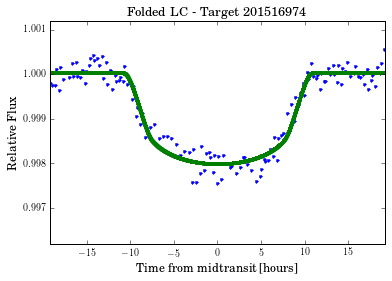

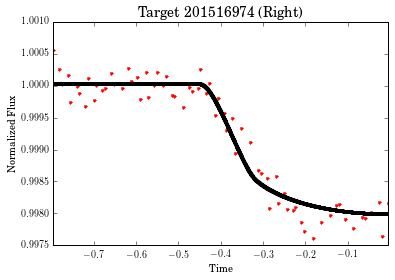

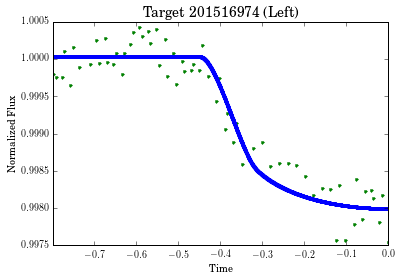

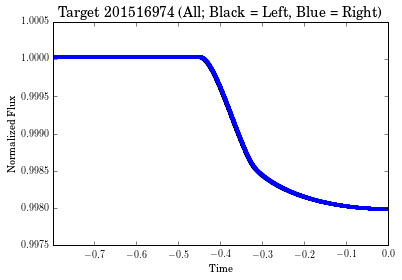

----------------------------------------------------------------

Transit model for star: 201920032
Optimization terminated successfully.
         Current function value: -648.982480
         Iterations: 414
         Function evaluations: 657


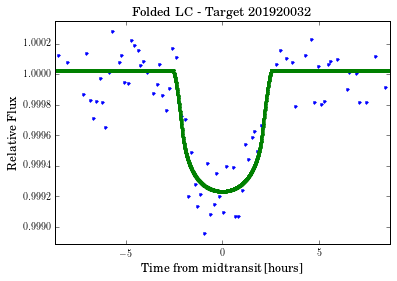

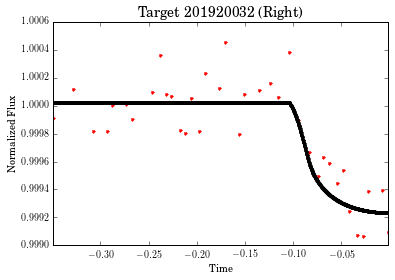

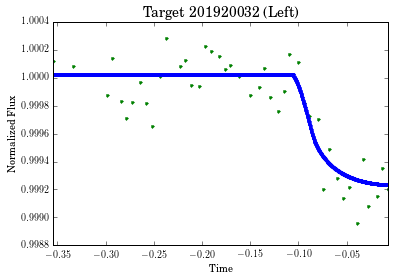

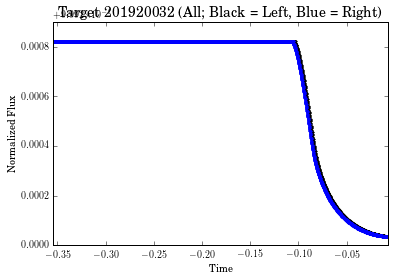

----------------------------------------------------------------

Transit model for star: 205924614
Optimization terminated successfully.
         Current function value: -1640.235898
         Iterations: 652
         Function evaluations: 990


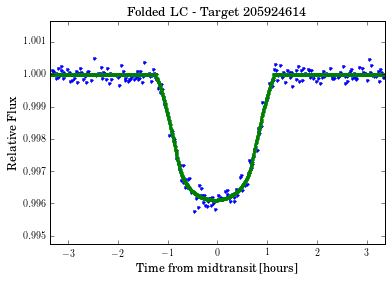

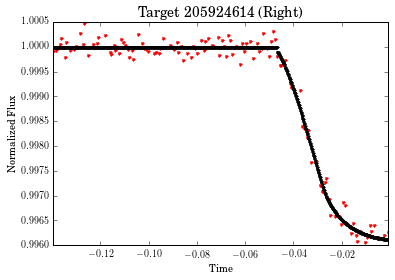

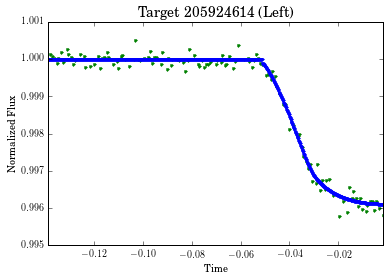

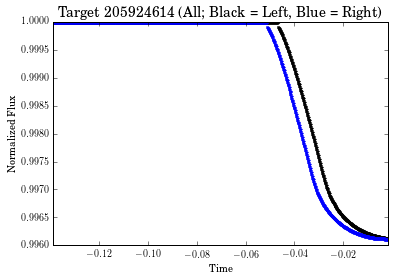

----------------------------------------------------------------

Transit model for star: 206029314
Optimization terminated successfully.
         Current function value: -907.617553
         Iterations: 727
         Function evaluations: 1102


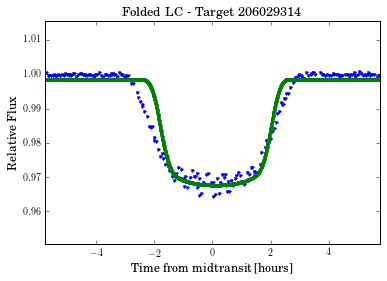

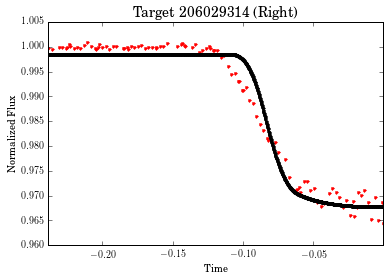

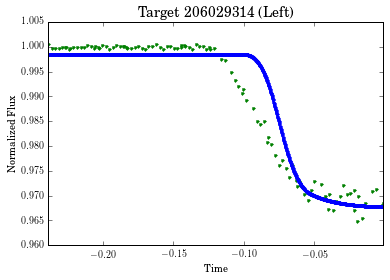

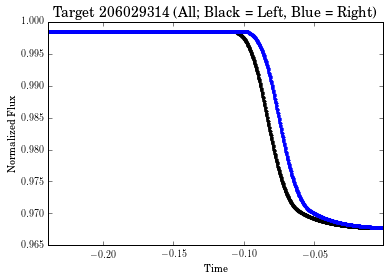

----------------------------------------------------------------

Transit model for star: 206038483
Optimization terminated successfully.
         Current function value: -1564.178418
         Iterations: 397
         Function evaluations: 633


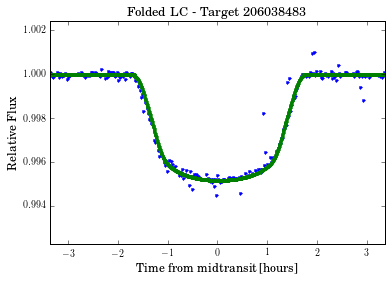

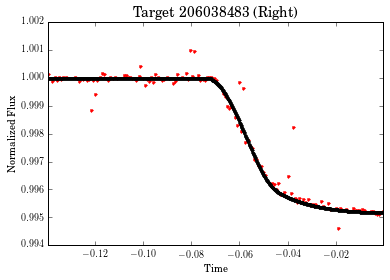

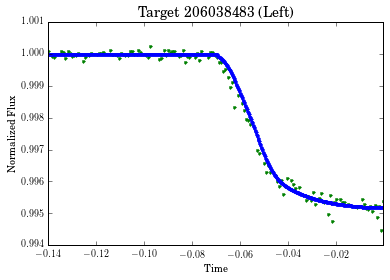

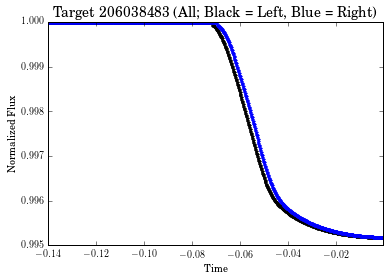

----------------------------------------------------------------

Transit model for star: 206061524
Optimization terminated successfully.
         Current function value: -727.059603
         Iterations: 514
         Function evaluations: 801


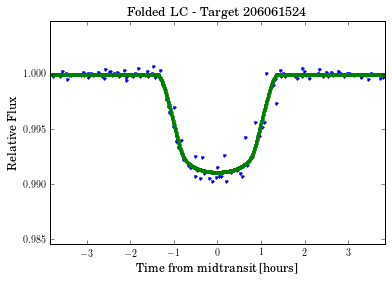

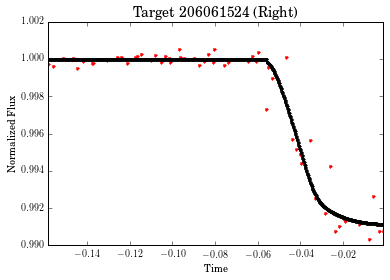

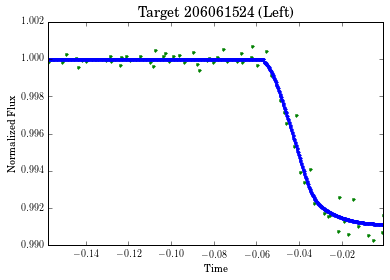

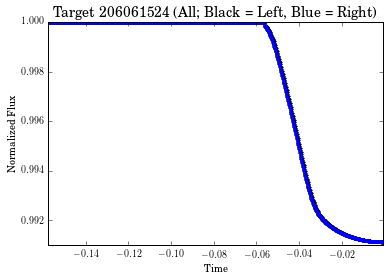

----------------------------------------------------------------

Transit model for star: 206082454
Optimization terminated successfully.
         Current function value: -343.140025
         Iterations: 921
         Function evaluations: 1389


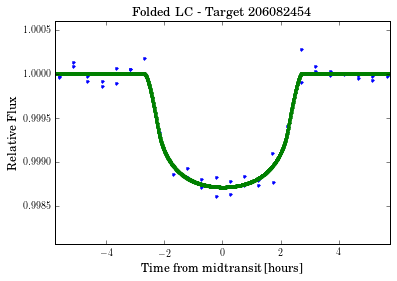

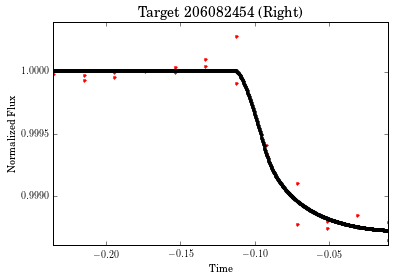

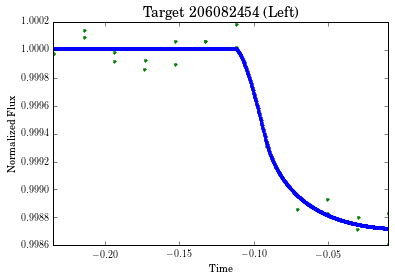

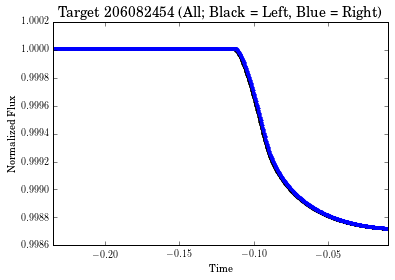

----------------------------------------------------------------

Transit model for star: 206155547


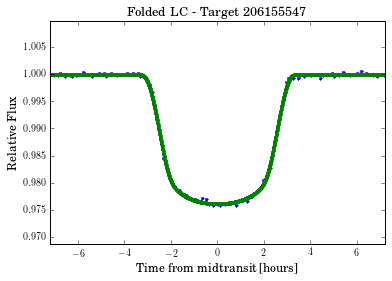

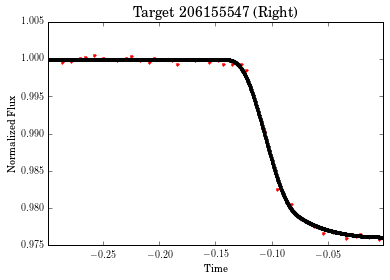

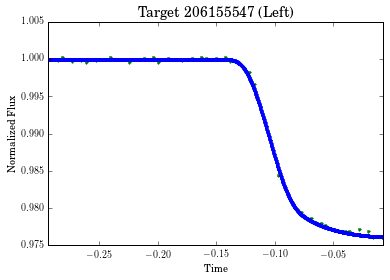

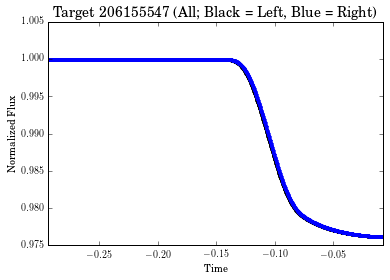

----------------------------------------------------------------

Transit model for star: 206245553
Optimization terminated successfully.
         Current function value: -906.509165
         Iterations: 911
         Function evaluations: 1397


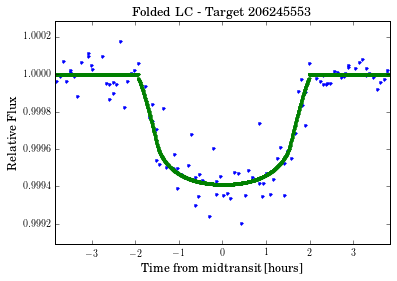

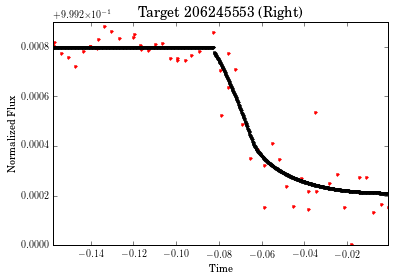

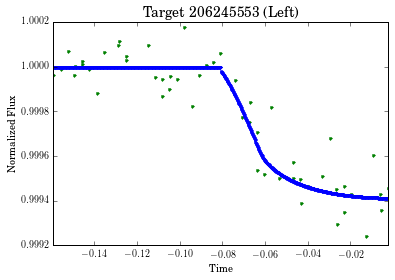

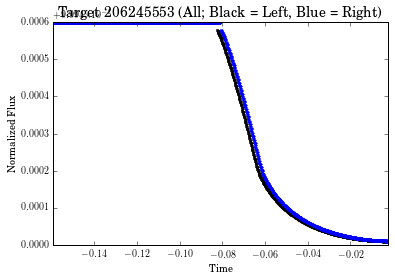

----------------------------------------------------------------


In [18]:
for star in new_targets:
    fixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
    print ""
    print "Transit model for star:", star.name
    t_theo, f_theo = model(star, fixed)
    mirror(star, f_theo, t_theo)
    print "----------------------------------------------------------------"

## Method 2: arctan

Mirror: Fold the folded LC again (goal: see what's happening with target 205924614)

def my_fit(x, amp, b, h_offset, v_offset):
    return amp*np.tanh(b*x + h_offset) + v_offset 
    #return np.tanh(x)

def initialParams(x, y):
    amplitude = np.max(y)-np.min(y)
    b = 1.0
    horizontal_offset = x[np.argmin(y)] #queremos la posición del valor del flujo más pequeño
    vertical_offset = np.min(y) #valor mínimo del flujo
    return [amplitude, b, horizontal_offset, vertical_offset] 

for star in new_targets: 
    
    right = np.where(star.dt > 0.0)
    f_right = star.f_trans[right]
    t_right = star.dt[right]*-1
    
    left = np.where(star.dt < 0.0)
    f_left = star.f_trans[left]
    t_left = star.dt[left]
    
    plt.figure(1)
    plt.plot(t_right, f_right, '.', c = 'r')
    plt.plot(t_left, f_left, '.', c = 'g')
    plt.title('Target '+star.name, fontsize = 14)
    plt.plot()
    
    x1 = t_right
    y1 = f_right
    
    x2 = t_left
    y2 = f_left
    
    p0_right = initialParams(x1, y1)
    p0_left = initialParams(x2, y2)
    
    popt_right, pcov_right = curve_fit(my_fit, x1, y1, p0 = p0_right) #Algorithm uses the Levenberg-Marquardt algorithm through leastsq. 
    popt_left, pcov_left = curve_fit(my_fit, x2, y2, p0 = p0_left)
    
    argsorts_right = np.argsort(x1) #Ordena el vector x1
    argsorts_left = np.argsort(x2) #Ordena el vector x2
    
    ypred_right = my_fit(x1, *popt_right)
    ypred_left = my_fit(x2, *popt_left)
    
    plt.figure(2)
    plt.title("Fitting of the right side of the folded LC", fontsize = 12)
    plt.plot(x1, y1, '.', c = 'r')
    plt.plot(x1[argsorts_right], ypred_right[argsorts_right], '-', c = 'k')
    plt.xlim(np.min(x1), np.max(x1))
    
    plt.figure(3)
    plt.title("Fitting of the left side of the folded LC", fontsize = 12)
    plt.plot(x2, y2, '.', c = 'g')
    plt.plot(x2[argsorts_left], ypred_left[argsorts_left], '-', c = 'k')
    plt.xlim(np.min(x2), np.max(x2))
       
    plt.figure(4)
    plt.title("Fit of each side (red = right, green = left)", fontsize = 12)
    plt.plot(x1[argsorts_right], ypred_right[argsorts_right], '-', c = 'r')
    plt.plot(x2[argsorts_left], ypred_left[argsorts_left], '-', c = 'g')
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.savefig('3_'+star.name+'fold_foldLC.jpg', dpi=800)
    plt.show()
    print "-----------------------------------------------"